In [2]:
import cv2
import datetime
import matplotlib
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

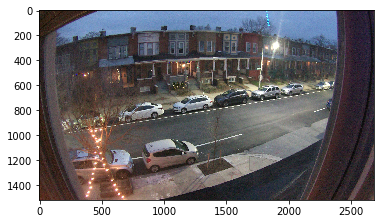

In [3]:
cal_path = "mounted-cars/calibration.jpg"
cal_color = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip
plt.imshow(cv2.cvtColor(cal_color, cv2.COLOR_BGR2RGB))

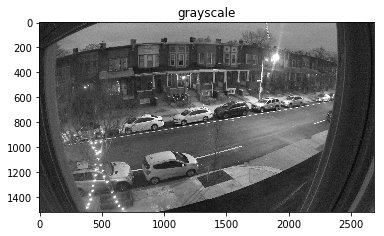

In [23]:
cal_path = "mounted-cars/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path, cv2.IMREAD_GRAYSCALE), -1 ) #read & flip
plt.imshow(cal, cmap='gray')
plt.title("grayscale");

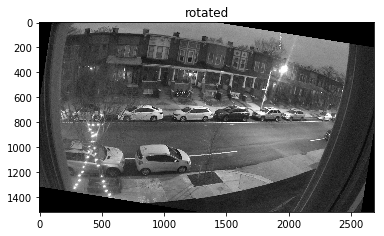

In [25]:
ROTATE_ANGLE = -9
rotated_cal = imutils.rotate(cal, angle=ROTATE_ANGLE) # rotate
plt.imshow(rotated_cal, cmap='gray')
plt.title("rotated");

Text(0.5, 1.0, 'calibration roi')

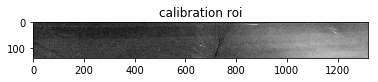

In [26]:
# crop to ROI
def get_roi(im):
    rotated = imutils.rotate(im, angle=ROTATE_ANGLE) # rotate
    return rotated[810:950, 680:2000] # clip
cal_roi = get_roi(cal)
plt.imshow(cal_roi, cmap='gray')
plt.title('calibration roi')

In [27]:
import numpy as np
car_p1 = np.array([745, 881])
car_p2 = np.array([900, 856])
car_length_px = np.linalg.norm(car_p2 - car_p1)
px_2_m = lambda px: 1.93 * (px / car_length_px)
m_2_px = lambda m: (m / 1.93) * car_length_px
print("pixels per meter= {}".format(m_2_px(1)))
mps_2_mph = lambda mps: mps * 2.23694

pixels per meter= 81.34880035288904


In [32]:
import dateutil.parser

# for two frames
paths=[
    'mounted-cars/2018-12-27T17:07:10.167307.jpg',
    'mounted-cars/2018-12-27T17:07:10.792036.jpg',
]

# compare the time
def parse_time(path):
    time_s = path.split("mounted-cars/")[1][:-4]
    return dateutil.parser.parse(time_s)

t0 = parse_time(paths[0])
t1 = parse_time(paths[1])

def read_deep_image(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.flip(im, -1) # flip

def read_roi(path):
    im = read_deep_image(path)
    return get_roi(im)

def subtract_bg(roi, cal):
    return roi - cal

TOO_HIGH = 250
def low_pass(no_bg):
    no_bg[no_bg > TOO_HIGH] = 0 # filter out too high values
    return no_bg

def read_roi_and_process(path, cal):
    roi = read_roi(path)
#     no_bg = subtract_bg(roi, cal)
#     lp = low_pass(roi)
    return roi


# find the max value (maybe headlight?)
def get_max_in_roi(path, cal):
    roi = read_roi_and_process(path, cal)
    max_v, max_idx = 0, None
    shape = roi.shape
    for r in range(0, shape[0]):
        for c in range(0, shape[1]):
            idx = (r, c)
            v = roi[idx]
            if v > max_v:
                max_v = v
                max_idx = idx
    return (max_idx, max_v)

delta_t = t1 - t0

# compute the distance
p0, v0 = get_max_in_roi(paths[0], cal_roi)
p1, v1 = get_max_in_roi(paths[1], cal_roi)

print(p0, v0)
print(p1, v1)

delta_p_pixels = np.linalg.norm(np.array(p1) - np.array(p0))
print("drove {}px in {} sec".format(delta_p_pixels, delta_t.total_seconds()))

delta_p_m = px_2_m(delta_p_pixels)
print("drove {}m in {} sec".format(delta_p_m, delta_t.total_seconds()))

speed_m = delta_p_m / delta_t.total_seconds()
print("car speed {} MPH".format(mps_2_mph(speed_m)))

(96, 570) 255
(72, 833) 255
drove 264.09278672466615px in 0.624729 sec
drove 3.246425092675471m in 0.624729 sec
car speed 11.624333345833904 MPH


In [33]:
def debug_im(path):
    im = read_roi_and_process(path, cal_roi)
    ax = plt.subplot()
    ax.imshow(im, cmap='gray')
    p, v = get_max_in_roi(path, cal_roi)
    r,c = p
    ax.set_title("max_pt={} value={}".format(p, v))
    ax.add_patch(matplotlib.patches.Rectangle((c, r), 10, 10, color='red'))

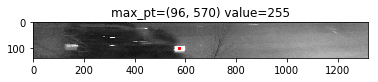

In [34]:
debug_im(paths[0])

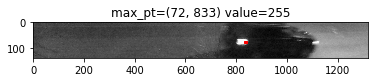

In [35]:
debug_im(paths[1])